# Hummingbird Classifier (Antioquia, Colombia)



In [1]:
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep
from fastai.vision.widgets import *
from duckduckgo_search import ddg_images

## Generate dataset from the internet

In [5]:
#This function returns a list of urls for images given a search term
#using duckduckgo as a search engine. 
def search_images(search_term, max_images = 100):
    return L(ddg_images(search_term, max_results=max_images)).itemgot('image')

Let's check if the function is working properly
 

In [7]:
urls = search_images('Adelomyia melanogenys', max_images = 1)
urls[0]

/home/haunted/miniconda3/envs/torch/lib/python3.8/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/home/haunted/miniconda3/envs/torch/lib/python3.8/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/home/haunted/miniconda3/envs/torch/lib/python3.8/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://www.naturephoto-cz.com/photos/mraz/adelomyia-melanogenys-12x_14b422.jpg'

### Now let's download the dataset


In [2]:
#Species names taken from https://colombia.inaturalist.org/guides/6144?sort=alphaname&taxon=5562
species = ['Adelomyia melanogenys', 'Aglaiocercus coelestis', 'Aglaiocercus kingii', 'Amazilia amabilis',
        'Amazilia franciae', 'Amazilia rosenbergi', 'Amazilia saucerottei', 'Amazilia tzacatl',
        'Androdon aequatorialis', 'Anthracothorax nigricollis', 'Boissonneaua flavescens', 
        'Boissonneaua jardini', 'Chaetocercus heliodor', 'Chaetocercus mulsant', 'Chalybura buffonii',
        'Chalybura urochrysia', 'Chlorostilbon gibsoni', 'Chlorostilbon melanorhynchus', 
        'Chrysolampis mosquitus', 'Coeligena coeligena', 'Coeligena torquata', 'Colibri coruscans',
        'Colibri delphinae', 'Colibri thalassinus', 'Discosura conversii', 'Doryfera ludovicae',
        'Ensifera ensifera', 'Eriocnemis vestita', 'Eutoxeres aquila', 'Florisuga mellivora', 
        'Glaucis hirsutus', 'Haplophaedia aureliae', 'Heliangelus exortis', 'Heliodoxa imperatrix',
        'Heliodoxa jacula', 'Heliodoxa leadbeateri', 'Heliodoxa rubinoides', 'Heliomaster longirostris',
        'Heliothryx barroti', 'Hylocharis eliciae', 'Klais guimeti', 'Lafresnaya lafresnayi',
        'Lepidopyga coeruleogularis', 'Lepidopyga goudoti', 'Metallura tyrianthina', 'Ocreatus underwoodii',
        'Phaethornis anthophilus', 'Phaethornis guy', 'Phaethornis longirostris', 'Phaethornis striigularis',
        'Phaethornis syrmatophorus', 'Phaethornis yaruqui', 'Ramphomicron microrhynchum', 'Schistes geoffroyi',
        'Threnetes ruckeri', 'Urochroa bougueri']
path = Path('Dataset/species')

In [36]:
for specie in species:
    dest = (path/specie) #Where to download
    dest.mkdir(exist_ok=True, parents=True) # Create dir if it doesn't exist
    download_images(dest, urls=search_images(f'{specie}', max_images=50))
    sleep(10)
    resize_images(path/specie, max_size=400, dest=path/specie) #resize all images to save space

## Now we can train our model using Fastai library

In [37]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed) #See how many images were not downloaded succesfully and erase them

17

In [14]:
?DataBlock

In [3]:
#Create data block to load data into resnet18 for finetunning
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=73),
    get_y=parent_label,
    item_tfms=[Resize(300, method='squish')],
    batch_tfms=aug_transforms(size=224)
).dataloaders(path)

dls.bs

64

### Visualize some of the data

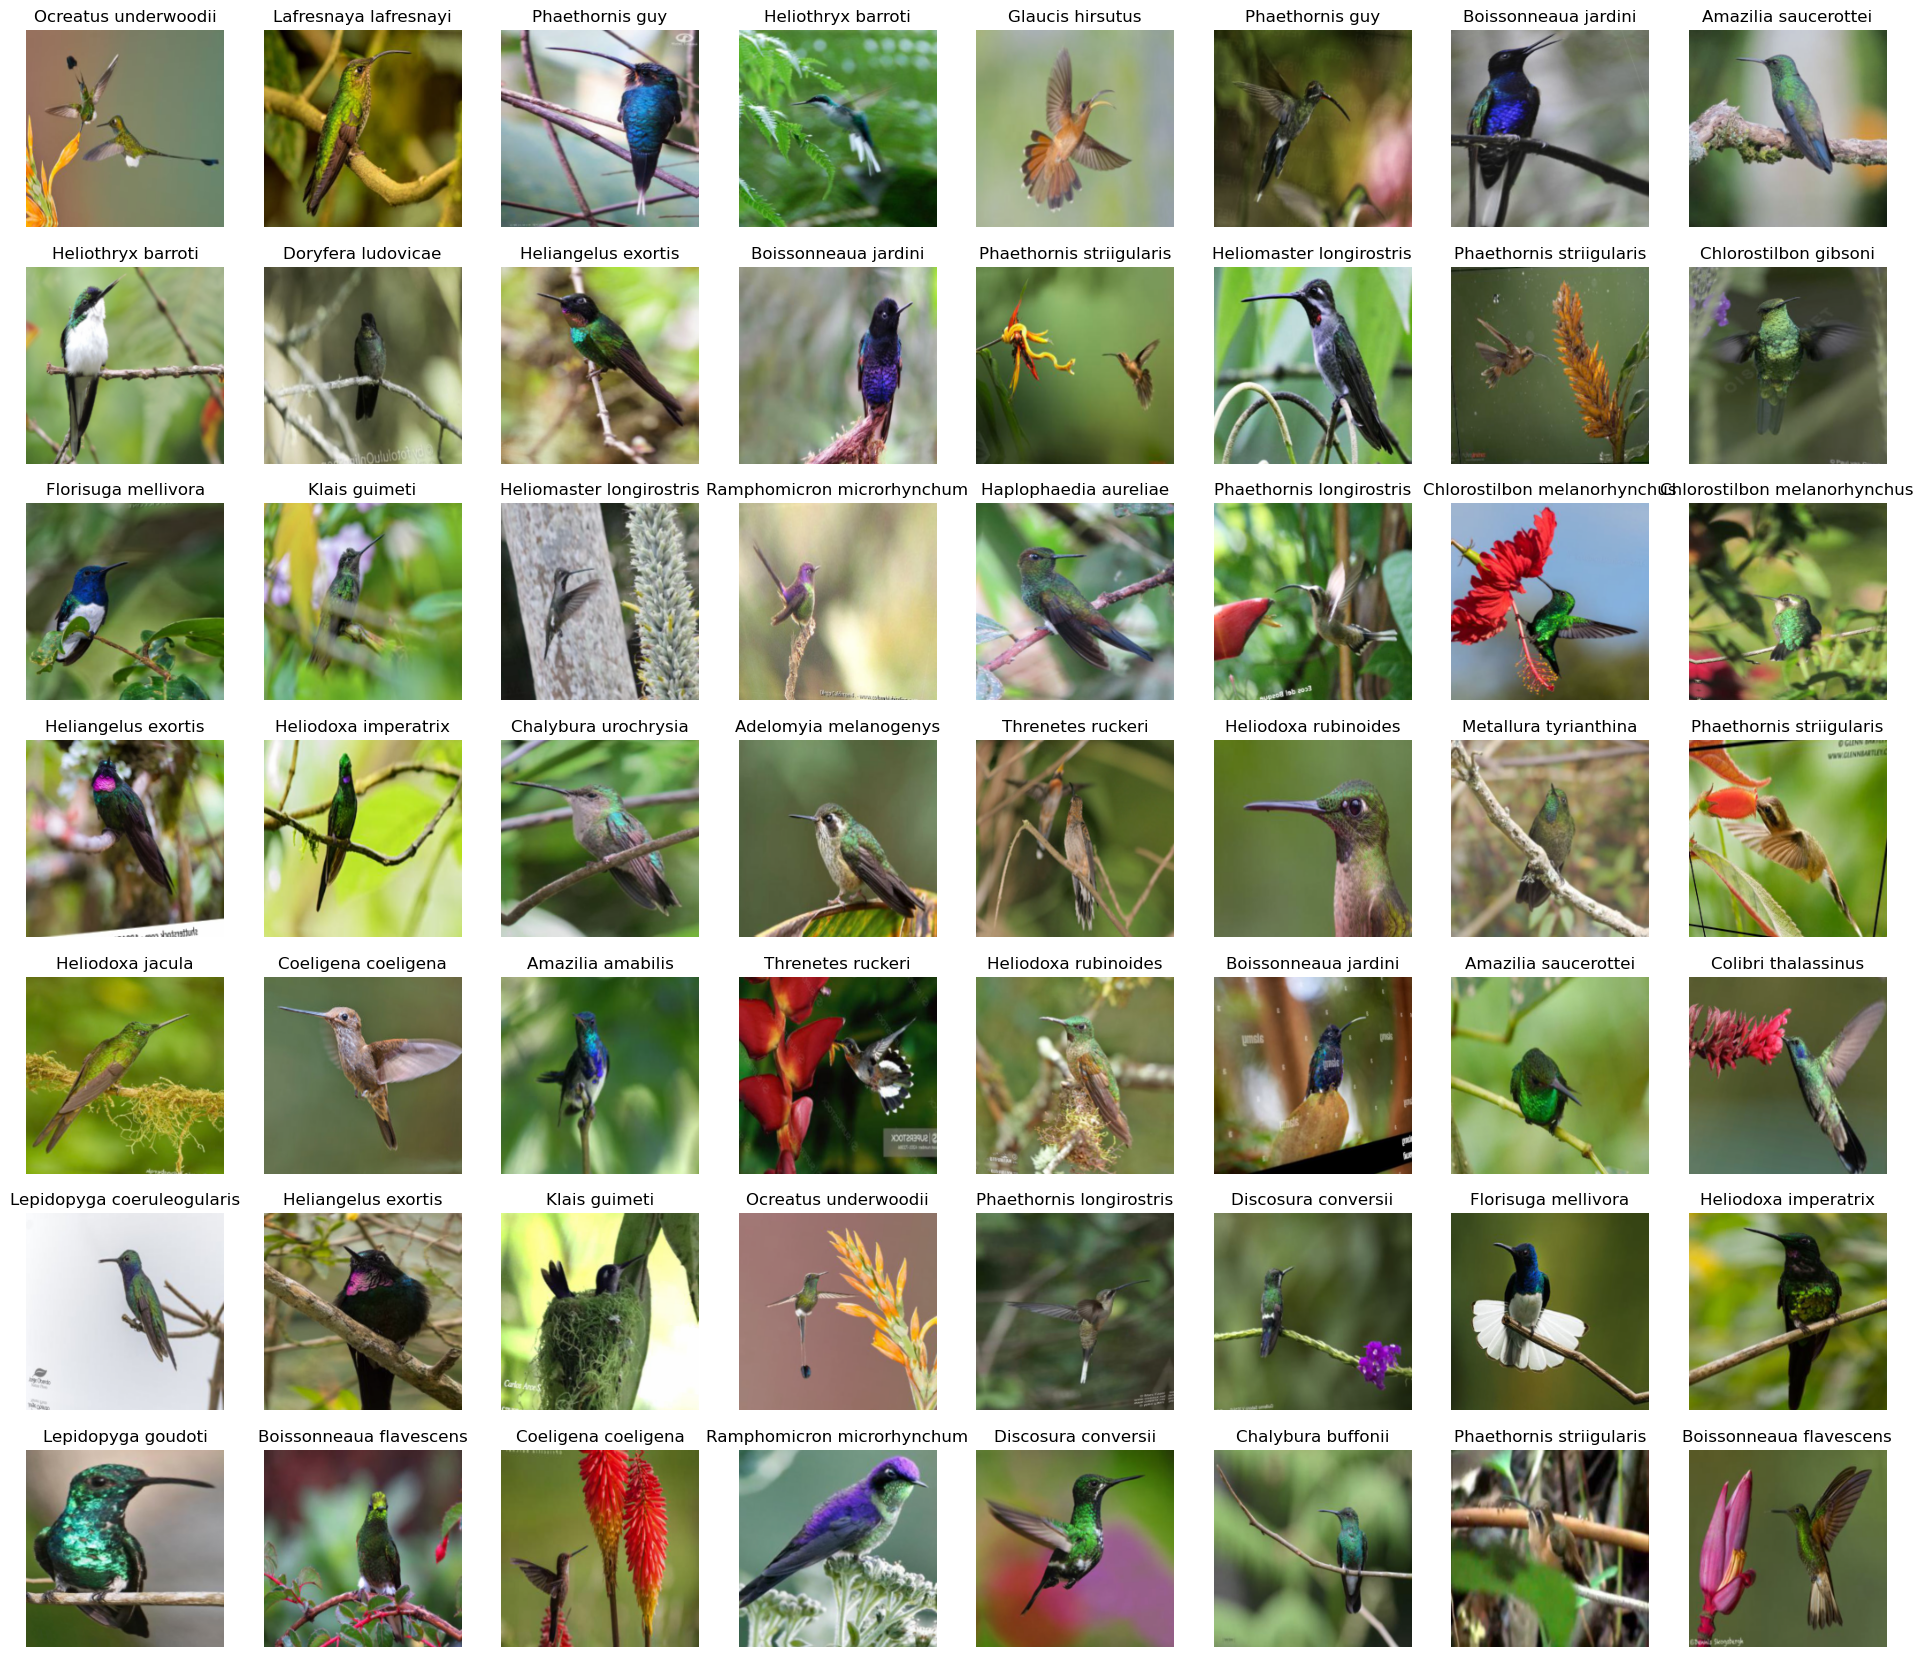

In [6]:
dls.show_batch(max_n=56) #

## Training the model

/home/haunted/miniconda3/envs/torch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/haunted/miniconda3/envs/torch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.001737800776027143)

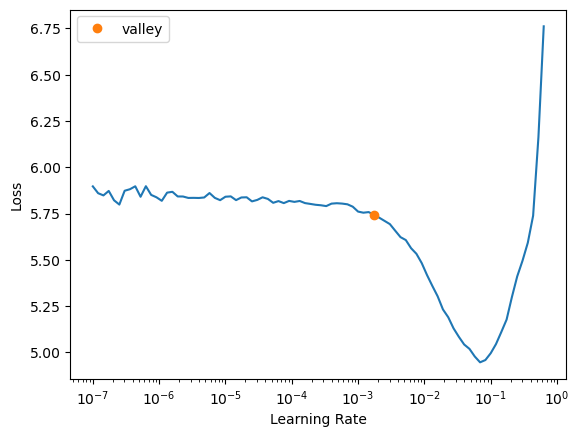

In [7]:
#Load data into a vision_learner object along with the resnet18 architecture
learn = vision_learner(dls, resnet18, metrics=error_rate)

#Find an optimal learning rate
learn.lr_find()

In [8]:
#Fine tune the model, if this doesn't run try reducing bs (batch size) in the DLS
learn.fine_tune(12, 1.73e-3)

### Now let's test the model

In [9]:
humming_type,_,probability = learn.predict(PILImage.create('test/Heliodoxa_jacula_test.jpg'))
print(f'This is a: {humming_type}')
print(f'Chances: {probability[0]:.4f}')

This is a: Heliodoxa jacula
Chances: 0.0001


In [10]:
learn.export('hummingbird_classifier_v3.pkl')

The model is working

In [11]:
learn = load_learner('hummingbird_classifier_v3.pkl')
learn.dls = dls
learn.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Now we will clean our data set using the trained model and generate a new version to be deployed


In [12]:
# Generate an object that allows us to diagnose our model and it's data
interp = ClassificationInterpretation.from_learner(learn)

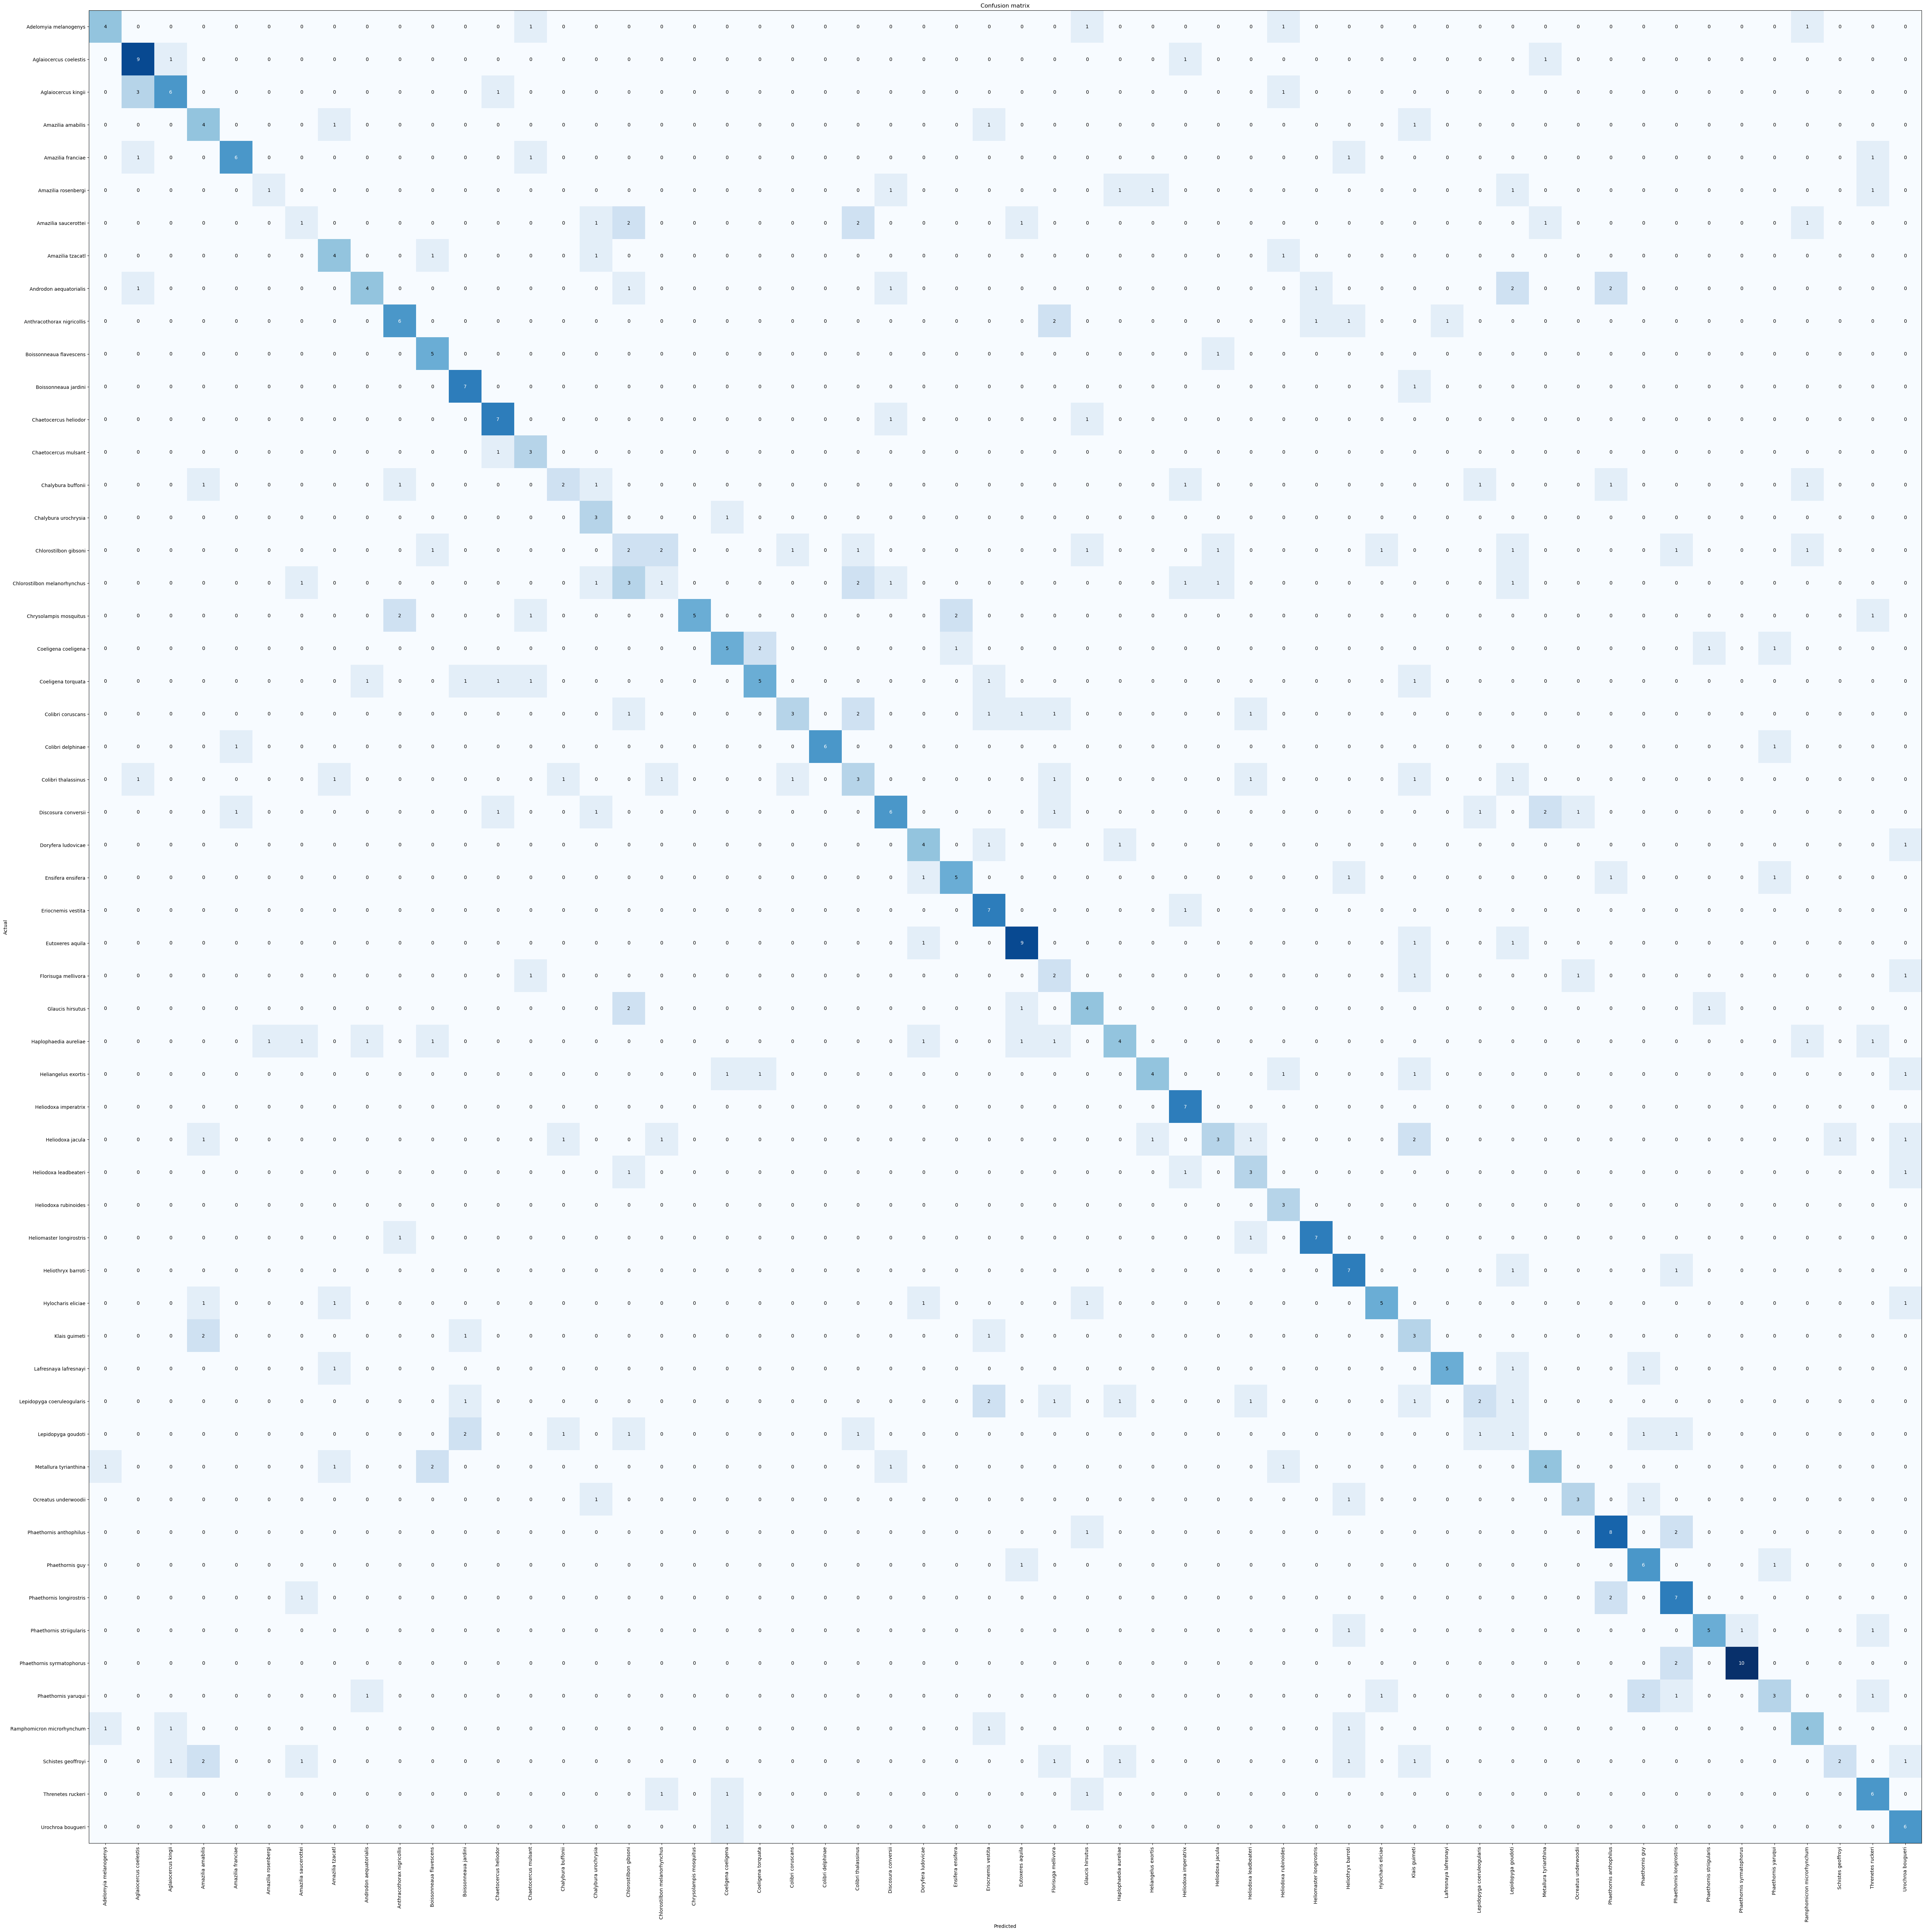

In [13]:
interp.plot_confusion_matrix(figsize=(56,56))

For V1 - Note while the model is very good at properly predicting some humming_bird sprecies. There's plenty of confusion for some of the species such as Phaertornis striigularis. After further, the main hyphotesis of the origin of this problems are basically that many species of hummingbird have very similar coloration and are fairly different to distinguish even for a trained eye.

For V2 - After fine tunning the model for more epochs and cleaning the data, the confusion matrix is much closer to having a complete diagonal (Only two species left which are very similar to others in the dataset). We suspect that further improving quaility of the data would result in an even better model and will be done in future iterations. 

For V3 - We finally achieve a complete diagonal. However there's still some mistakes being made by the network. We also noticed that there's still data that doesn't belong to bird pictures. 

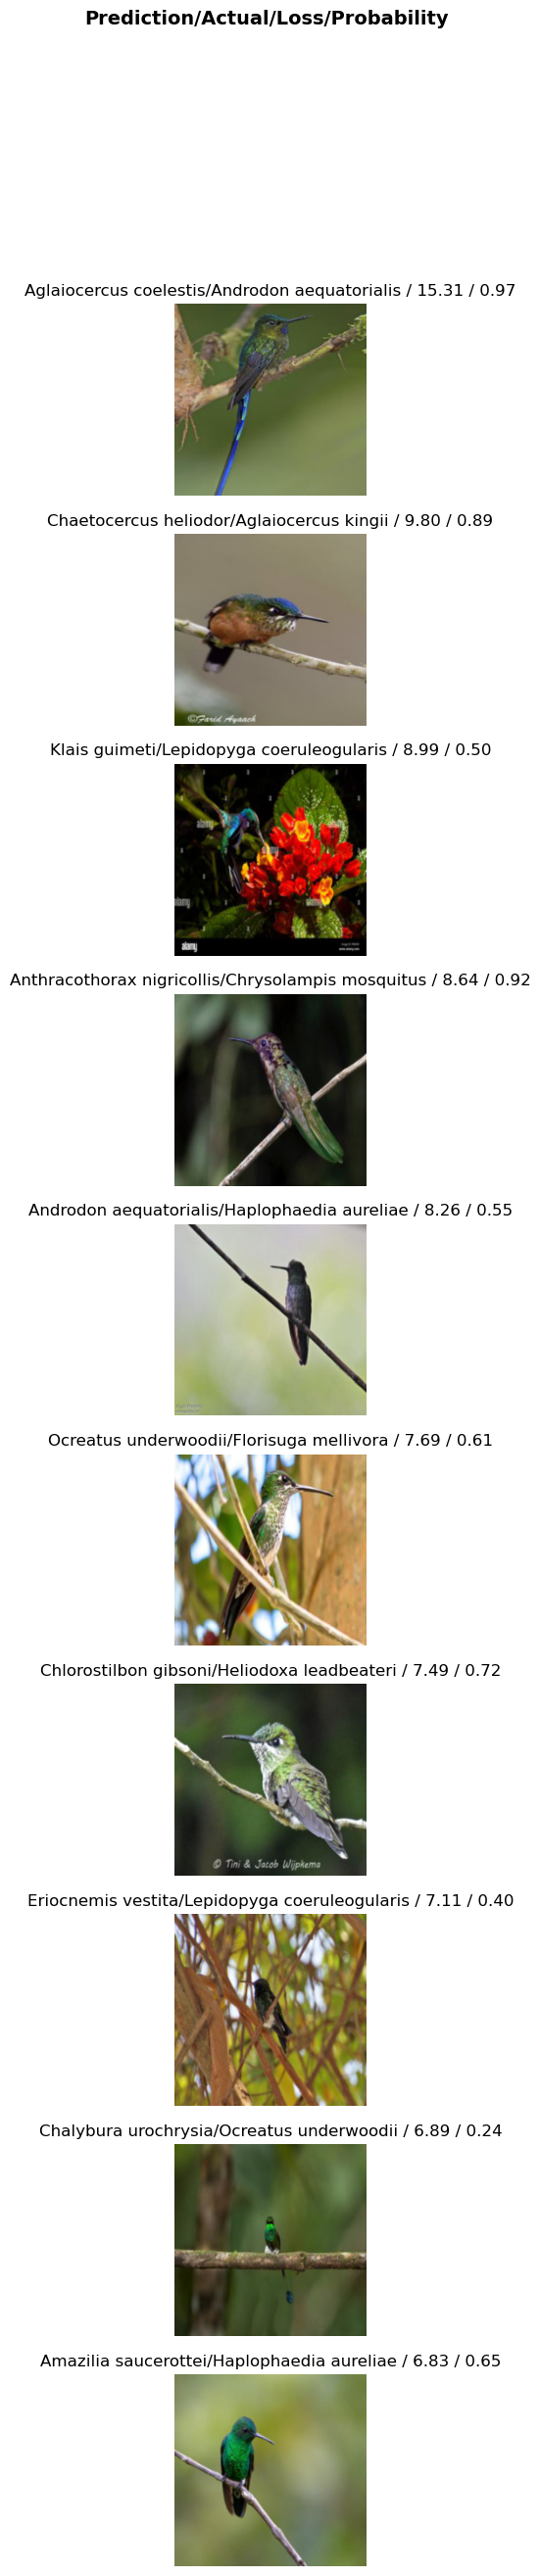

In [14]:
interp.plot_top_losses(10, nrows=10)
#prediction, actual (target label), loss, and probability. 
#The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction

In [15]:
# Now we want to create a cleaner object that allows us to somewhat polish the data set
cleaner = ImageClassifierCleaner(learn)
cleaner

After scanning looking carefully at the top losses on each species we believe a main source of error is the heavy presence of vegetation in some of the pictures. This problem can be adressed by cropping the pictures in such a way it focuses on the bird. Segmentation will be performed on further iterations of the dataset.

In [ ]:
# Now we will delete some pictures in which the birds are practically unrecognizable or they aren't actually
# pictures of birds.
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

If wanted we can now proceed to retrain the model. 